In [14]:
# importing relevant packages 

import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F
import glob
import os
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import json
from PIL import Image
import random
import albumentations as A
import glob
from shapely.geometry import Polygon

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 45em; }</style>"))
pd.options.display.max_columns = None

/tmp/ipykernel_8312/2198079538.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
class VGG_model(nn.Module):
    def __init__(self):
        super(VGG_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.avgpool = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,50, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(output_size=(8,8))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(3200, 300),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(300, 32),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VGG_model()
model.load_state_dict(torch.load('./Model_VGG_4_5_2000_13080_epoch'))
model = model.to(device)

In [5]:
def predict_keypoints(img):
    img = cv2.resize(img, (224,224))
    img_tensor = transforms.ToTensor()(img)
    img_mean = img_tensor.mean(dim = (1,2))
    img_std = img_tensor.std(dim = (1,2))
        
    img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
    img_normalised = img_normalised.to(device)
    
    key_points = model(img_normalised[None]).flatten().detach().cpu().numpy()
    
    return key_points

In [6]:
def plot_keypoints(img, keypoints):                                                             

    plt.imshow(img)

    keypoints = np.array(keypoints)
    
    x_points = keypoints[0::2]
    y_points = keypoints[1::2]
    
    plt.scatter(x_points*img.shape[1], y_points*img.shape[0], s = 4, c=(1,0,0))
    plt.show()

In [7]:
def process_num(x):
    return x*random.uniform(0.95, 1.05)

In [8]:
def process_label(x):
    string_to_int_dict = {'orange':0, 'pear':1, 'banana':2, 'plum':3, 'egg':4, 'strawberry':5, 'chicken':6, 'bayberry':7, 'redgrape':8, 'pistachio':9}
    return string_to_int_dict[x]


In [9]:
def transform_image(img):
    img = cv2.resize(img, (224,224))
    img_tensor = transforms.ToTensor()(img)
    img_mean = img_tensor.mean(dim = (1,2))
    img_std = img_tensor.std(dim = (1,2))
        
    img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
    return img_normalised

In [10]:
def augment_data():

    source_folder = os.path.join(os. getcwd(), 'Grasp_dataset_2')
    destination_folder = os.path.join(os. getcwd(), 'Grasp_dataset_augmented')
    dataset_names = ['Grasp_dataset_orange', 'Grasp_dataset_pear', 'Grasp_dataset_banana', 'Grasp_dataset_plum', 'Grasp_dataset_egg', 'Grasp_dataset_strawberry', 'Grasp_dataset_chicken', 'Grasp_dataset_bayberry', 'Grasp_dataset_redgrape', 'Grasp_dataset_pistachio']

    for f in dataset_names:
        
        files = glob.glob(destination_folder + '/' + f + '/*')
        
        for file in files:
            os.remove(file)
        
        df = pd.read_csv(source_folder + '/' + f + '/' + f + '.csv')
        
        num_cols = df.select_dtypes(include=['float']).columns
        df[num_cols] = df[num_cols].applymap(process_num)
        df['label'] = df['label'].apply(process_label)
        
#         df.to_csv(destination_folder + '/' + f + '/' + f + '.csv', index=False)
        
        i = 0
        repeat = 0
        
        header = ['p1_x', 'p1_y', 'p2_x', 'p2_y', 'p3_x', 'p3_y', 'p4_x', 'p4_y', 'p5_x', 'p5_y', 'p6_x', 'p6_y',
              'p7_x', 'p7_y', 'p8_x', 'p8_y', 'p9_x', 'p9_y', 'p10_x', 'p10_y', 'p11_x', 'p11_y', 'p12_x', 'p12_y', 'p13_x',
              'p13_y', 'p14_x', 'p14_y', 'p15_x', 'p15_y', 'p16_x', 'p16_y']
            
        keypoints_df = pd.DataFrame(columns=header)
        
        while i < df.shape[0]:
        
            transform = A.Compose([
                    A.Affine(rotate=random.uniform(-1, 1), p=1),
                    A.Affine(translate_percent={'x': random.uniform(-0.02, 0.02), 'y': random.uniform(-0.02, 0.02)}, p=1),
                    A.Affine(shear={'x': random.uniform(-1, 1), 'y': random.uniform(-0.5, 0.5)}, p=1),
                    A.Affine(scale=(0.98, 1.01), p=1)
                ], keypoint_params=A.KeypointParams(format='xy'))
            
            image_to_be_transformed = cv2.imread(os.path.join(source_folder + '/' + f, df.iloc[i]['image_name']))
            
            processed_image_to_be_transformed = transform_image(image_to_be_transformed)
            processed_image_to_be_transformed = processed_image_to_be_transformed.to(device)

            keypoints = model(processed_image_to_be_transformed[None]).flatten().detach().cpu().numpy()
            
            x_points = keypoints[0::2]
            y_points = keypoints[1::2]
            x_points = x_points*image_to_be_transformed.shape[1]
            y_points = y_points*image_to_be_transformed.shape[0]

            transformed = transform(image=image_to_be_transformed, keypoints=list(zip(x_points, y_points)))
            transformed_image = transformed['image']
            transformed_keypoints = transformed['keypoints']
            
            if repeat >= 20:
                print('skipping')
                repeat = 0
                i = i + 1
                continue
    
            if len(transformed_keypoints) != 16:
#                 print(df.iloc[i]['image_name'])
                repeat = repeat + 1
                continue
            
            flatten_coordinates = np.array(transformed_keypoints).flatten()
            flatten_coordinates[::2] = [x / transformed_image.shape[1] for x in flatten_coordinates[::2]]
            flatten_coordinates[1::2] = [x / transformed_image.shape[0] for x in flatten_coordinates[1::2]]
            keypoints_df.loc[len(keypoints_df)] = pd.Series(flatten_coordinates, index=header)
#             print(flatten_coordinates)
#             print(keypoints_df)
            
#             transformed_image[..., [0, 2]] = transformed_image[..., [2, 0]]
#             img = Image.fromarray(np.uint8(transformed_image))
#             img.save(destination_folder + '/' + f + '/' + df.iloc[i]['image_name'])
            
#             plot_keypoints(transformed_image, flatten_coordinates)
            
            repeat = 0
            i = i + 1
        
        complete_df = pd.concat([df, keypoints_df], axis=1)
        complete_df.to_csv(destination_folder + '/' + f + '/' + f + '.csv', index=False)


In [ ]:
# test_image = cv2.imread('/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/Grasp_dataset_augmented/Grasp_dataset_orange/Gimage10.jpg')
# test_keypoints = [0.12771776,0.2779994,0.47523814,0.025530297,0.8148705,0.2775899,0.8246956,0.62812585,0.49508992,0.9256545,0.15821105,0.73071223,0.43649036,0.20082472,0.40966305,0.36028758,0.39995593,0.49125895,0.41422606,0.61616457,0.44915825,0.75999326,0.52863693,0.7681227,0.5525919,0.6140371,0.5610489,0.49106207,0.5443897,0.3638414,0.51417565,0.20984803]
# print(len(test_keypoints))
# plot_keypoints(test_image, test_keypoints)

In [11]:
def combine_datasets():

    destination_folder = os.path.join(os. getcwd(), 'Grasp_dataset_augmented')
    dataset_names = ['Grasp_dataset_orange', 'Grasp_dataset_pear', 'Grasp_dataset_banana', 'Grasp_dataset_plum', 'Grasp_dataset_egg', 'Grasp_dataset_strawberry', 'Grasp_dataset_chicken', 'Grasp_dataset_bayberry', 'Grasp_dataset_redgrape', 'Grasp_dataset_pistachio']

    complete_df_set = pd.DataFrame()
    first_dataset = True

    for f in dataset_names:

        df = pd.read_csv(destination_folder + '/' + f + '/' + f + '.csv')

        if first_dataset == True:
            complete_df_set = df
            first_dataset = False
        else:
            complete_df_set = pd.concat([complete_df_set, df], axis=0)

    complete_df_set.to_csv(destination_folder + '/' + 'Grasp_dataset_augmented.csv', index=False)


In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# augment_data()
# combine_datasets()

# grasp_dataset = pd.read_csv(os. getcwd() + '/' + 'Grasp_dataset_augmented/Grasp_dataset_augmented.csv')

# print(grasp_dataset.tail(2))


# data_train, data_test, label_train, label_test = train_test_split(grasp_data, grasp_label, test_size=0.2, random_state=np.random.randint(100))

# clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=np.random.randint(100))

# num_folds = 10
# cv_method = KFold(n_splits=num_folds, shuffle=True, random_state=np.random.randint(100))
# cv_results = cross_val_score(clf, grasp_data, grasp_label, cv=cv_method, scoring='accuracy')

# print('Cross-validation results:', cv_results)
# print('Average accuracy:', cv_results.mean())


In [12]:
class ClassifierDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.data, self.label = self.clean_data(df)
        
        
    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        label = self.label.iloc[idx]
#         label = F.one_hot(torch.tensor(label), 10)
        
        return torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.int64).to(device)
    
    def __len__(self):
        return self.data.shape[0]

    
    def clean_data(self, grasp_dataset):
        grasp_data = grasp_dataset.drop(columns=['image_name', 'label'], axis=1)
        grasp_data['pressure_reading_1'] = grasp_data['pressure_reading_1'] / 100
        grasp_data['pressure_reading_2'] = grasp_data['pressure_reading_2'] / 100
        grasp_data['force_reading_1'] = grasp_data['force_reading_1'] / 1000
        grasp_data['force_reading_2'] = grasp_data['force_reading_2'] / 1000
        grasp_label = grasp_dataset['label']

        return grasp_data, grasp_label

In [ ]:
# grasp_dataset = pd.read_csv(os. getcwd() + '/' + 'Grasp_dataset_augmented/Grasp_dataset_augmented.csv')

# train_df, test_df = train_test_split(grasp_dataset, test_size=0.1)

# train_dataset = ClassifierDataset(train_df)
# test_dataset = ClassifierDataset(test_df)

# train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

# for data in train_dataloader:
#     break

# input_data, target_output = data
# print(input_data)
# print(target_output)

In [16]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(16*2+4, 32),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Dropout(0.4),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        return self.layers(x)



In [17]:
classification_model = MLP()
classification_model = classification_model.to(device)

In [18]:
summary(classification_model, (8,16*2+4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 8, 32]           1,184
         LeakyReLU-2                [-1, 8, 32]               0
           Dropout-3                [-1, 8, 32]               0
            Linear-4                [-1, 8, 10]             330
Total params: 1,514
Trainable params: 1,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [19]:
def update_training_set():

    global train_df, test_df, train_dataset, test_dataset, train_dataloader, test_dataloader, image_data
    
    destination_folder = os.path.join(os. getcwd(), 'Grasp_dataset_augmented')

    augment_data()
    combine_datasets()
    
    grasp_dataset = pd.read_csv(os. getcwd() + '/' + 'Grasp_dataset_augmented/Grasp_dataset_augmented.csv')
    
    train_df, test_df = train_test_split(grasp_dataset, test_size=0.1)
    
    train_dataset = ClassifierDataset(train_df)
    test_dataset = ClassifierDataset(test_df)
    
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
    
    print('Finished.')

In [24]:
update_training_set()

Finished.


In [20]:
def get_essentials():
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.0001)
    return loss_fun, optimizer

In [21]:
def train_batch(data, model, loss_fun, optimizer):
    model.train()
    input_data, target_output = data
    pred_output = model(input_data)
    loss = loss_fun(pred_output, target_output)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
    model.eval()
    input_data, target_output = data
    pred_output = model(input_data.to(torch.float32))
    loss = loss_fun(pred_output, target_output)
    return loss.item()


In [22]:
epochs = 1000
loss_fun, optimizer = get_essentials()

In [25]:
train_epoch, val_epoch = [], []
for epoch in tqdm(range(epochs)):
    train_batch_losses, val_batch_losses = [], []
    for data in train_dataloader:
        train_batch_loss = train_batch(data, classification_model, loss_fun, optimizer)
        train_batch_losses.append(train_batch_loss)
    for data in test_dataloader:
        val_batch_loss = val_batch(data, classification_model, loss_fun, optimizer)
        val_batch_losses.append(val_batch_loss)
    train_epoch.append(np.mean(train_batch_losses))
    val_epoch.append(np.mean(val_batch_losses))

    if epoch % 5 == 0:
        print(train_batch_loss, val_batch_loss)
    
    if (epoch) % 100 == 0:
        torch.save(classification_model.state_dict(), './Temp_models/Model_classify_dataset_2' + str(epoch) + '_epoch')
        update_training_set()

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

2.4248130321502686 2.29685115814209


  0%|▏                                         | 3/1000 [00:10<44:24,  2.67s/it]

Finished.


  1%|▎                                         | 7/1000 [00:10<13:25,  1.23it/s]

2.2857284545898438 2.4026060104370117


  1%|▍                                        | 11/1000 [00:10<06:14,  2.64it/s]

2.354349136352539 2.207288980484009


  2%|▋                                        | 17/1000 [00:11<02:56,  5.57it/s]

2.181241512298584 2.2950453758239746


  2%|▉                                        | 23/1000 [00:12<02:00,  8.14it/s]

2.243722438812256 2.321903944015503


  3%|█                                        | 27/1000 [00:12<01:40,  9.68it/s]

2.2074546813964844 2.284503221511841


  3%|█▎                                       | 33/1000 [00:12<01:32, 10.42it/s]

2.1788523197174072 2.202578544616699


  4%|█▌                                       | 37/1000 [00:13<01:27, 11.02it/s]

2.2834935188293457 2.2692763805389404


  4%|█▊                                       | 43/1000 [00:13<01:22, 11.55it/s]

2.1426634788513184 2.1926379203796387


  5%|█▉                                       | 47/1000 [00:14<01:21, 11.69it/s]

2.102346897125244 2.1734564304351807


  5%|██▏                                      | 53/1000 [00:14<01:22, 11.53it/s]

2.016756534576416 2.170365810394287


  6%|██▎                                      | 57/1000 [00:15<01:21, 11.64it/s]

2.1143903732299805 2.121262550354004


  6%|██▌                                      | 63/1000 [00:15<01:25, 11.00it/s]

2.061544895172119 2.058863878250122


  7%|██▋                                      | 67/1000 [00:15<01:21, 11.44it/s]

2.2491750717163086 2.201289176940918


  7%|██▉                                      | 73/1000 [00:16<01:18, 11.74it/s]

2.025810480117798 2.0556211471557617


  8%|███▏                                     | 77/1000 [00:16<01:20, 11.47it/s]

1.8703227043151855 2.167318105697632


  8%|███▍                                     | 83/1000 [00:17<01:19, 11.49it/s]

1.9876444339752197 1.793365240097046


  9%|███▌                                     | 87/1000 [00:17<01:21, 11.25it/s]

2.207216739654541 1.999913215637207


  9%|███▊                                     | 93/1000 [00:18<01:20, 11.32it/s]

1.5394339561462402 2.1936798095703125


 10%|███▉                                     | 97/1000 [00:18<01:19, 11.37it/s]

1.9488887786865234 1.8712680339813232


 10%|████                                     | 99/1000 [00:18<01:19, 11.35it/s]

2.135087490081787 1.844224214553833


 10%|████                                    | 103/1000 [00:28<16:49,  1.13s/it]

Finished.


 11%|████▎                                   | 107/1000 [00:29<08:53,  1.67it/s]

1.6576426029205322 2.1890065670013428


 11%|████▌                                   | 113/1000 [00:29<03:53,  3.80it/s]

2.0744028091430664 1.6250219345092773


 12%|████▋                                   | 117/1000 [00:30<02:36,  5.66it/s]

2.1171693801879883 1.6998213529586792


 12%|████▉                                   | 123/1000 [00:30<01:45,  8.30it/s]

2.0233161449432373 1.860728144645691


 13%|█████                                   | 127/1000 [00:31<01:34,  9.27it/s]

2.126221179962158 1.4643471240997314


 13%|█████▎                                  | 133/1000 [00:31<01:25, 10.13it/s]

1.8942409753799438 1.8057329654693604


 14%|█████▍                                  | 137/1000 [00:32<01:22, 10.40it/s]

1.45365571975708 1.639040231704712


 14%|█████▋                                  | 143/1000 [00:32<01:20, 10.64it/s]

1.8303461074829102 1.7864439487457275


 15%|█████▉                                  | 147/1000 [00:32<01:18, 10.80it/s]

1.289435625076294 1.7353805303573608


 15%|██████                                  | 151/1000 [00:33<01:19, 10.66it/s]

1.554404377937317 1.7455081939697266


 16%|██████▎                                 | 157/1000 [00:34<01:31,  9.23it/s]

1.973475694656372 1.826965570449829


 16%|██████▌                                 | 163/1000 [00:34<01:21, 10.28it/s]

1.1369212865829468 1.2981168031692505


 17%|██████▋                                 | 167/1000 [00:35<01:19, 10.49it/s]

0.7722699046134949 1.2417912483215332


 17%|██████▉                                 | 173/1000 [00:35<01:15, 10.90it/s]

1.6215894222259521 1.4341001510620117


 18%|███████                                 | 177/1000 [00:35<01:12, 11.30it/s]

1.5845215320587158 1.2705169916152954


 18%|███████▎                                | 183/1000 [00:36<01:08, 11.86it/s]

0.9365864992141724 1.4854816198349


 19%|███████▍                                | 187/1000 [00:36<01:13, 11.02it/s]

1.9327354431152344 0.9405303597450256


 19%|███████▋                                | 193/1000 [00:37<01:12, 11.13it/s]

1.7390363216400146 1.6486494541168213


 20%|███████▉                                | 197/1000 [00:37<01:11, 11.18it/s]

1.3989534378051758 1.7173497676849365


 20%|███████▉                                | 199/1000 [00:37<01:11, 11.14it/s]

1.7153875827789307 1.3108001947402954


 20%|████████                                | 203/1000 [00:48<15:59,  1.20s/it]

Finished.


 21%|████████▎                               | 207/1000 [00:49<08:22,  1.58it/s]

1.370091199874878 1.6012978553771973


 21%|████████▌                               | 213/1000 [00:49<03:35,  3.66it/s]

1.493502140045166 1.1369819641113281


 22%|████████▋                               | 217/1000 [00:50<02:18,  5.64it/s]

1.4660148620605469 1.4735641479492188


 22%|████████▉                               | 223/1000 [00:50<01:30,  8.59it/s]

0.892124354839325 1.394869089126587


 23%|█████████                               | 227/1000 [00:50<01:17, 10.02it/s]

1.311795711517334 0.8139792680740356


 23%|█████████▎                              | 233/1000 [00:51<01:08, 11.13it/s]

1.1478654146194458 1.458086609840393


 24%|█████████▍                              | 237/1000 [00:51<01:06, 11.43it/s]

1.5893648862838745 1.648261308670044


 24%|█████████▋                              | 243/1000 [00:52<01:05, 11.62it/s]

0.8255089521408081 1.5325419902801514


 25%|█████████▉                              | 247/1000 [00:52<01:04, 11.71it/s]

1.2472578287124634 1.5035369396209717


 25%|██████████                              | 253/1000 [00:53<01:03, 11.77it/s]

0.908884584903717 0.736426055431366


 26%|██████████▎                             | 257/1000 [00:53<01:03, 11.79it/s]

2.8438401222229004 1.4443864822387695


 26%|██████████▌                             | 263/1000 [00:53<01:03, 11.67it/s]

0.698175847530365 0.9370375275611877


 27%|██████████▋                             | 267/1000 [00:54<01:02, 11.64it/s]

1.7154769897460938 1.6270925998687744


 27%|██████████▉                             | 273/1000 [00:54<01:01, 11.80it/s]

1.7839545011520386 1.6654150485992432


 28%|███████████                             | 277/1000 [00:55<01:01, 11.76it/s]

1.7806495428085327 1.461032509803772


 28%|███████████▎                            | 283/1000 [00:55<01:01, 11.73it/s]

1.8236373662948608 1.3550455570220947


 29%|███████████▍                            | 287/1000 [00:56<01:00, 11.85it/s]

1.2663911581039429 1.0343048572540283


 29%|███████████▋                            | 293/1000 [00:56<01:08, 10.32it/s]

2.072629928588867 1.1490119695663452


 30%|███████████▉                            | 297/1000 [00:56<01:04, 10.87it/s]

1.1285467147827148 1.4783625602722168


 30%|███████████▉                            | 299/1000 [00:57<01:04, 10.94it/s]

1.4132040739059448 1.4560821056365967


 30%|████████████                            | 303/1000 [01:08<14:35,  1.26s/it]

Finished.


 31%|████████████▎                           | 307/1000 [01:08<07:40,  1.51it/s]

1.299005150794983 1.4072996377944946


 31%|████████████▌                           | 313/1000 [01:09<03:19,  3.45it/s]

1.2102890014648438 1.1104962825775146


 32%|████████████▋                           | 317/1000 [01:09<02:10,  5.25it/s]

0.6275392174720764 0.970608651638031


 32%|████████████▉                           | 323/1000 [01:10<01:26,  7.84it/s]

1.3372902870178223 1.5940594673156738


 33%|█████████████                           | 327/1000 [01:10<01:14,  9.04it/s]

0.7192209959030151 1.1838605403900146


 33%|█████████████▎                          | 333/1000 [01:11<01:07,  9.95it/s]

2.7000107765197754 1.873552680015564


 34%|█████████████▍                          | 337/1000 [01:11<01:02, 10.61it/s]

1.5745089054107666 1.2746049165725708


 34%|█████████████▋                          | 343/1000 [01:12<00:57, 11.39it/s]

1.5229074954986572 1.2397011518478394


 35%|█████████████▉                          | 347/1000 [01:12<00:57, 11.26it/s]

1.4867570400238037 1.5430827140808105


 35%|██████████████                          | 353/1000 [01:13<00:58, 11.07it/s]

0.5272753834724426 2.084683895111084


 36%|██████████████▎                         | 357/1000 [01:13<00:58, 11.01it/s]

1.5721440315246582 1.214576005935669


 36%|██████████████▌                         | 363/1000 [01:14<00:58, 10.97it/s]

1.5629122257232666 1.3962368965148926


 37%|██████████████▋                         | 367/1000 [01:14<00:56, 11.16it/s]

1.254357099533081 0.8096919655799866


 37%|██████████████▉                         | 373/1000 [01:15<00:58, 10.71it/s]

1.6771070957183838 1.9558684825897217


 38%|███████████████                         | 377/1000 [01:15<00:56, 11.10it/s]

1.3807048797607422 2.2786710262298584


 38%|███████████████▎                        | 383/1000 [01:15<00:54, 11.27it/s]

1.9532504081726074 1.3958176374435425


 39%|███████████████▍                        | 387/1000 [01:16<00:55, 11.07it/s]

1.058756947517395 0.7952250242233276


 39%|███████████████▋                        | 393/1000 [01:16<00:55, 10.96it/s]

1.3189809322357178 1.3969043493270874


 40%|███████████████▉                        | 397/1000 [01:17<00:55, 10.85it/s]

1.4802987575531006 0.9562358856201172


 40%|███████████████▉                        | 399/1000 [01:17<00:55, 10.87it/s]

1.4454656839370728 1.3439629077911377


 40%|████████████████                        | 403/1000 [01:28<12:15,  1.23s/it]

Finished.


 41%|████████████████▎                       | 407/1000 [01:29<06:24,  1.54it/s]

1.3295350074768066 1.518587350845337


 41%|████████████████▌                       | 413/1000 [01:29<02:43,  3.59it/s]

1.493241548538208 0.7691002488136292


 42%|████████████████▋                       | 417/1000 [01:29<01:45,  5.51it/s]

0.7684895396232605 1.0859407186508179


 42%|████████████████▉                       | 423/1000 [01:30<01:10,  8.23it/s]

1.03725004196167 1.28682279586792


 43%|█████████████████                       | 427/1000 [01:30<00:59,  9.61it/s]

0.8462668061256409 1.3169898986816406


 43%|█████████████████▎                      | 433/1000 [01:31<00:53, 10.60it/s]

0.746780514717102 1.0728354454040527


 44%|█████████████████▍                      | 437/1000 [01:31<00:50, 11.25it/s]

1.505517601966858 1.3281831741333008


 44%|█████████████████▋                      | 443/1000 [01:32<00:49, 11.34it/s]

0.866671621799469 0.8653428554534912


 45%|█████████████████▉                      | 447/1000 [01:32<00:48, 11.37it/s]

1.2549171447753906 1.398282527923584


 45%|██████████████████                      | 453/1000 [01:33<00:48, 11.34it/s]

1.185979962348938 1.143394947052002


 46%|██████████████████▎                     | 457/1000 [01:33<00:47, 11.55it/s]

1.5559788942337036 1.5869770050048828


 46%|██████████████████▌                     | 463/1000 [01:33<00:46, 11.64it/s]

0.9471601843833923 0.9425745010375977


 47%|██████████████████▋                     | 467/1000 [01:34<00:45, 11.71it/s]

1.2039512395858765 1.3391461372375488


 47%|██████████████████▉                     | 473/1000 [01:34<00:44, 11.74it/s]

1.3615198135375977 1.4411091804504395


 48%|███████████████████                     | 477/1000 [01:35<00:44, 11.71it/s]

1.2178550958633423 1.024594783782959


 48%|███████████████████▎                    | 483/1000 [01:35<00:45, 11.48it/s]

0.8362970352172852 1.3760521411895752


 49%|███████████████████▍                    | 487/1000 [01:36<00:44, 11.41it/s]

0.8602567911148071 1.2851862907409668


 49%|███████████████████▋                    | 493/1000 [01:36<00:43, 11.67it/s]

1.007452368736267 1.0330393314361572


 50%|███████████████████▉                    | 497/1000 [01:36<00:42, 11.80it/s]

0.8986705541610718 1.2606505155563354


 50%|███████████████████▉                    | 499/1000 [01:37<00:42, 11.74it/s]

2.1515145301818848 1.0664817094802856


 50%|████████████████████                    | 502/1000 [01:48<12:30,  1.51s/it]

Finished.


 51%|████████████████████▎                   | 508/1000 [01:49<04:18,  1.90it/s]

0.9596070051193237 0.8466301560401917


 51%|████████████████████▍                   | 512/1000 [01:49<02:24,  3.38it/s]

2.089329719543457 1.2255234718322754


 52%|████████████████████▋                   | 518/1000 [01:50<01:16,  6.27it/s]

1.1616191864013672 1.0379385948181152


 52%|████████████████████▉                   | 522/1000 [01:50<01:02,  7.70it/s]

0.845562219619751 0.773398756980896


 53%|█████████████████████                   | 528/1000 [01:51<00:47,  9.84it/s]

1.3073012828826904 0.7691991925239563


 53%|█████████████████████▎                  | 532/1000 [01:51<00:44, 10.62it/s]

1.808021068572998 1.3649977445602417


 54%|█████████████████████▌                  | 538/1000 [01:51<00:41, 11.04it/s]

0.6770451664924622 1.2360707521438599


 54%|█████████████████████▋                  | 542/1000 [01:52<00:41, 11.12it/s]

1.6432181596755981 1.901048183441162


 55%|█████████████████████▉                  | 548/1000 [01:52<00:39, 11.52it/s]

0.6493583917617798 1.3909705877304077


 55%|██████████████████████                  | 552/1000 [01:53<00:39, 11.48it/s]

1.0511243343353271 1.7038649320602417


 56%|██████████████████████▎                 | 558/1000 [01:53<00:38, 11.50it/s]

1.137694239616394 1.1270897388458252


 56%|██████████████████████▍                 | 562/1000 [01:54<00:38, 11.42it/s]

0.840435802936554 1.025680422782898


 57%|██████████████████████▋                 | 568/1000 [01:54<00:37, 11.57it/s]

0.34315216541290283 0.9564545154571533


 57%|██████████████████████▉                 | 572/1000 [01:54<00:37, 11.42it/s]

1.0883636474609375 0.9012182354927063


 58%|███████████████████████                 | 578/1000 [01:55<00:36, 11.63it/s]

1.2114053964614868 1.4663934707641602


 58%|███████████████████████▎                | 582/1000 [01:55<00:35, 11.64it/s]

1.3576154708862305 1.5707533359527588


 59%|███████████████████████▌                | 588/1000 [01:56<00:35, 11.60it/s]

0.7960290908813477 1.3874083757400513


 59%|███████████████████████▋                | 592/1000 [01:56<00:35, 11.44it/s]

2.055372714996338 1.3198223114013672


 60%|███████████████████████▉                | 598/1000 [01:57<00:34, 11.63it/s]

1.0128412246704102 1.413696050643921


 60%|████████████████████████                | 600/1000 [01:57<00:34, 11.54it/s]

0.9298181533813477 1.3031307458877563


 60%|████████████████████████                | 602/1000 [02:08<11:24,  1.72s/it]

Finished.


 61%|████████████████████████▎               | 608/1000 [02:08<04:14,  1.54it/s]

1.072872519493103 1.672008752822876


 61%|████████████████████████▍               | 612/1000 [02:09<02:21,  2.73it/s]

1.3470120429992676 0.7721134424209595


 62%|████████████████████████▋               | 618/1000 [02:09<01:10,  5.40it/s]

1.0809413194656372 1.9188168048858643


 62%|████████████████████████▉               | 622/1000 [02:10<00:51,  7.33it/s]

2.0623250007629395 1.5623655319213867


 63%|█████████████████████████               | 628/1000 [02:10<00:39,  9.38it/s]

1.1994476318359375 1.1278669834136963


 63%|█████████████████████████▎              | 632/1000 [02:11<00:36, 10.06it/s]

1.5367017984390259 0.9511792659759521


 64%|█████████████████████████▌              | 638/1000 [02:11<00:36,  9.99it/s]

1.220280408859253 0.45720773935317993


 64%|█████████████████████████▋              | 642/1000 [02:12<00:33, 10.81it/s]

0.6167205572128296 0.7630761861801147


 65%|█████████████████████████▉              | 648/1000 [02:12<00:31, 11.33it/s]

0.9776562452316284 0.8490351438522339


 65%|██████████████████████████              | 652/1000 [02:12<00:29, 11.69it/s]

0.612262487411499 1.4221389293670654


 66%|██████████████████████████▎             | 658/1000 [02:13<00:29, 11.73it/s]

1.1427021026611328 0.9373910427093506


 66%|██████████████████████████▍             | 662/1000 [02:13<00:28, 11.77it/s]

2.244194984436035 1.307464838027954


 67%|██████████████████████████▋             | 668/1000 [02:14<00:29, 11.10it/s]

1.1279817819595337 0.9002763628959656


 67%|██████████████████████████▉             | 672/1000 [02:14<00:29, 11.27it/s]

2.0699572563171387 0.7913851737976074


 68%|███████████████████████████             | 676/1000 [02:15<00:28, 11.38it/s]

0.8366365432739258 1.3096624612808228


 68%|███████████████████████████▎            | 682/1000 [02:15<00:30, 10.49it/s]

1.6342132091522217 0.9449506998062134


 69%|███████████████████████████▌            | 688/1000 [02:16<00:29, 10.58it/s]

1.333129644393921 1.1075620651245117


 69%|███████████████████████████▋            | 692/1000 [02:16<00:28, 10.70it/s]

0.6623180508613586 0.8479746580123901


 70%|███████████████████████████▉            | 698/1000 [02:17<00:28, 10.63it/s]

0.7337512969970703 1.3087639808654785


 70%|████████████████████████████            | 700/1000 [02:17<00:30,  9.92it/s]

1.3855634927749634 1.0334500074386597


 70%|████████████████████████████            | 702/1000 [02:28<08:45,  1.76s/it]

Finished.


 71%|████████████████████████████▎           | 708/1000 [02:29<03:14,  1.50it/s]

0.6160056591033936 1.323479413986206


 71%|████████████████████████████▍           | 712/1000 [02:29<01:47,  2.68it/s]

1.7739121913909912 0.49814552068710327


 72%|████████████████████████████▋           | 718/1000 [02:30<00:54,  5.18it/s]

1.2434163093566895 0.3133470416069031


 72%|████████████████████████████▉           | 722/1000 [02:30<00:39,  7.06it/s]

1.964617371559143 0.7802289724349976


 73%|█████████████████████████████           | 728/1000 [02:31<00:29,  9.19it/s]

0.9001022577285767 1.3202875852584839


 73%|█████████████████████████████▎          | 732/1000 [02:31<00:26,  9.97it/s]

0.6351098418235779 1.6309826374053955


 74%|█████████████████████████████▌          | 738/1000 [02:32<00:24, 10.53it/s]

1.4305641651153564 0.316424697637558


 74%|█████████████████████████████▋          | 742/1000 [02:32<00:24, 10.67it/s]

0.8931564688682556 1.2724103927612305


 75%|█████████████████████████████▉          | 748/1000 [02:33<00:23, 10.76it/s]

0.8593676090240479 1.2161750793457031


 75%|██████████████████████████████          | 752/1000 [02:33<00:22, 10.80it/s]

0.8781535625457764 0.7838135957717896


 76%|██████████████████████████████▎         | 758/1000 [02:33<00:22, 10.80it/s]

1.5053136348724365 0.9160943031311035


 76%|██████████████████████████████▍         | 762/1000 [02:34<00:22, 10.76it/s]

1.0709900856018066 1.0416096448898315


 77%|██████████████████████████████▋         | 768/1000 [02:34<00:21, 10.92it/s]

1.1392865180969238 1.2632865905761719


 77%|██████████████████████████████▉         | 772/1000 [02:35<00:20, 10.98it/s]

1.6013072729110718 0.8356034755706787


 78%|███████████████████████████████         | 776/1000 [02:35<00:20, 11.01it/s]

0.6786525845527649 0.24617135524749756


 78%|███████████████████████████████▎        | 782/1000 [02:36<00:22,  9.82it/s]

0.5498515367507935 0.4083496034145355


 79%|███████████████████████████████▌        | 788/1000 [02:36<00:20, 10.58it/s]

0.8797621726989746 0.6826512813568115


 79%|███████████████████████████████▋        | 792/1000 [02:37<00:19, 10.73it/s]

0.9682726860046387 0.4336477220058441


 80%|███████████████████████████████▉        | 798/1000 [02:37<00:18, 10.77it/s]

0.7569205164909363 0.7017827033996582


 80%|████████████████████████████████        | 800/1000 [02:37<00:18, 10.79it/s]

0.6475389003753662 0.8366495370864868


 80%|████████████████████████████████        | 802/1000 [02:48<05:38,  1.71s/it]

Finished.


 81%|████████████████████████████████▎       | 808/1000 [02:49<02:04,  1.54it/s]

0.8888722658157349 0.42890632152557373


 81%|████████████████████████████████▍       | 812/1000 [02:49<01:08,  2.74it/s]

1.7348991632461548 1.4807159900665283


 82%|████████████████████████████████▋       | 818/1000 [02:50<00:34,  5.34it/s]

0.7102688550949097 1.7328205108642578


 82%|████████████████████████████████▉       | 822/1000 [02:50<00:24,  7.18it/s]

0.9267090559005737 0.9297206401824951


 83%|█████████████████████████████████       | 828/1000 [02:51<00:18,  9.13it/s]

0.9213534593582153 1.1859452724456787


 83%|█████████████████████████████████▎      | 832/1000 [02:51<00:16, 10.07it/s]

0.7542043924331665 2.1841464042663574


 84%|█████████████████████████████████▍      | 836/1000 [02:52<00:15, 10.39it/s]

0.7424297332763672 2.03076171875


 84%|█████████████████████████████████▋      | 842/1000 [02:52<00:15, 10.45it/s]

0.4307573139667511 1.219367504119873


 85%|█████████████████████████████████▉      | 848/1000 [02:53<00:14, 10.64it/s]

0.7572188973426819 1.1638526916503906


 85%|██████████████████████████████████      | 852/1000 [02:53<00:13, 10.84it/s]

1.1993719339370728 0.9207321405410767


 86%|██████████████████████████████████▎     | 858/1000 [02:54<00:13, 10.80it/s]

1.3532524108886719 1.1402044296264648


 86%|██████████████████████████████████▍     | 862/1000 [02:54<00:12, 11.30it/s]

1.1595346927642822 1.06600821018219


 87%|██████████████████████████████████▋     | 868/1000 [02:54<00:11, 11.56it/s]

0.8103994131088257 0.3757500648498535


 87%|██████████████████████████████████▉     | 872/1000 [02:55<00:10, 11.65it/s]

0.412275493144989 0.4312261641025543


 88%|███████████████████████████████████     | 878/1000 [02:55<00:10, 11.83it/s]

1.3176895380020142 0.6660757064819336


 88%|███████████████████████████████████▎    | 882/1000 [02:56<00:09, 11.82it/s]

0.792519748210907 1.8140347003936768


 89%|███████████████████████████████████▌    | 888/1000 [02:56<00:09, 11.80it/s]

0.5155467987060547 0.7107765674591064


 89%|███████████████████████████████████▋    | 892/1000 [02:57<00:09, 11.81it/s]

0.7144719362258911 0.6549569964408875


 90%|███████████████████████████████████▉    | 898/1000 [02:57<00:08, 11.73it/s]

0.9603883028030396 1.6172397136688232


 90%|████████████████████████████████████    | 900/1000 [02:57<00:08, 11.79it/s]

0.9740595817565918 1.025432825088501


 90%|████████████████████████████████████    | 902/1000 [03:08<02:47,  1.71s/it]

Finished.


 91%|████████████████████████████████████▎   | 908/1000 [03:09<00:59,  1.54it/s]

0.9740614891052246 0.8377923369407654


 91%|████████████████████████████████████▍   | 912/1000 [03:09<00:32,  2.75it/s]

1.0541713237762451 0.8540735840797424


 92%|████████████████████████████████████▋   | 918/1000 [03:10<00:15,  5.43it/s]

1.013615369796753 0.7094341516494751


 92%|████████████████████████████████████▉   | 922/1000 [03:10<00:10,  7.31it/s]

0.5481793880462646 1.4315986633300781


 93%|█████████████████████████████████████   | 928/1000 [03:11<00:07,  9.39it/s]

0.9294846653938293 1.0970768928527832


 93%|█████████████████████████████████████▎  | 932/1000 [03:11<00:06, 10.16it/s]

1.4115961790084839 0.5729780793190002


 94%|█████████████████████████████████████▌  | 938/1000 [03:11<00:05, 10.73it/s]

0.36741214990615845 1.3637704849243164


 94%|█████████████████████████████████████▋  | 942/1000 [03:12<00:05, 10.91it/s]

0.6091346144676208 0.8607017993927002


 95%|█████████████████████████████████████▉  | 948/1000 [03:12<00:04, 11.03it/s]

1.0882105827331543 0.6757508516311646


 95%|██████████████████████████████████████  | 952/1000 [03:13<00:04, 11.11it/s]

1.8842484951019287 0.7960858345031738


 96%|██████████████████████████████████████▎ | 958/1000 [03:13<00:03, 11.16it/s]

1.5181069374084473 0.7074170708656311


 96%|██████████████████████████████████████▍ | 962/1000 [03:14<00:03, 11.20it/s]

0.588660717010498 1.0220763683319092


 97%|██████████████████████████████████████▋ | 968/1000 [03:14<00:02, 11.26it/s]

1.1742881536483765 1.6522918939590454


 97%|██████████████████████████████████████▉ | 972/1000 [03:15<00:02, 11.25it/s]

0.6176053285598755 1.0755277872085571


 98%|███████████████████████████████████████ | 978/1000 [03:15<00:01, 11.35it/s]

0.3314458727836609 0.9294689893722534


 98%|███████████████████████████████████████▎| 982/1000 [03:15<00:01, 11.32it/s]

0.5122813582420349 0.4248674511909485


 99%|███████████████████████████████████████▌| 988/1000 [03:16<00:01, 11.06it/s]

1.254155158996582 0.7150352001190186


 99%|███████████████████████████████████████▋| 992/1000 [03:16<00:00, 11.06it/s]

1.1034834384918213 0.4180237650871277


100%|███████████████████████████████████████▉| 998/1000 [03:17<00:00, 10.91it/s]

1.0458556413650513 1.398269534111023


100%|███████████████████████████████████████| 1000/1000 [03:17<00:00,  5.06it/s]


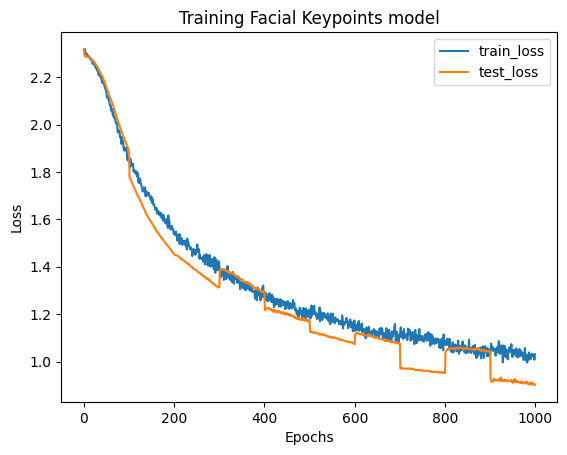

In [26]:
plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Facial Keypoints model")
plt.show()

In [ ]:
# correct = 0
# total = 0
# # since we're not training, we don't need to calculate the gradients for our outputs
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         # calculate outputs by running images through the network
#         outputs = net(images)
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
